# Demo of diverse/similar subset sampling

In [1]:
from functions import \
    similar_or_diverse, \
    split_dataset_diversity, \
    extract_gist_features
import os
import random
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt

Using TensorFlow backend.


## Sampling from a point cloud

Here, we sample a point cloud uniformly from $(0, 1)^2$, then take two subsamples from the original sample, one with points spaced as far apart as possible and one with points packed as closely as possible.

In [2]:
def create_point_cloud(n):
    """sample uniformly from (0, 1)^2"""
    x = [random.random() for _ in range(n)]
    y = [random.random() for _ in range(n)]
    return np.stack([x, y], 1)

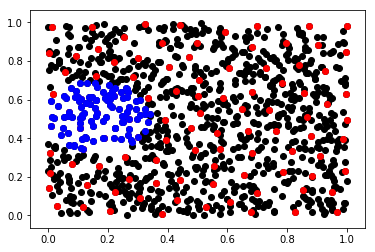

In [3]:
# create random point cloud
point_cloud = create_point_cloud(1000)

k = 100

# sample 
far_points, _ = similar_or_diverse(point_cloud, k, 'diverse')
near_points, _ = similar_or_diverse(point_cloud, k, 'similar')

# plot
plt.scatter(point_cloud[:, 0], point_cloud[:, 1], c='black')
plt.scatter(far_points[:, 0], far_points[:, 1], c='red')
plt.scatter(near_points[:, 0], near_points[:, 1], c='blue')

Black points are the original sample, red points are the diverse subset, and blue points are the similar subset. We do not force the two subsamples to be disjoint, so there may be some points in both subsets.

## Sampling images

This time, we embed images using gist features, then subsample from that space, and take a qualitative look at how similar or diverse the two subsamples appear.

For this example, we use the CIFAR-10 dataset.

Since the algorithm requires the construction of a distance matrix, which gets very expensive quickly as we increase the number of observations, we will consider one class (e.g., airplanes, birds, dogs, etc.) at a time.

In [4]:
# load the cifar-10 data
cifar = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar.load_data()

# extract gist features
# extract gist features
if 'cifar_gist_features.npy' not in os.listdir():
    x_gist = extract_gist_features(x_train, NBLOCKS)
    np.save('./cifar_gist_features.npy', x_gist)
else:
    x_gist = np.load('cifar_gist_features.npy')

In [5]:
images_to_sample = 16

class_to_sample = 3  # cats

# subset images to this class
x_class = x_train[y_train.flatten() == class_to_sample, :, :, :]
x_gist_class = x_gist[y_train.flatten() == class_to_sample, :]

In [6]:
diverse_images, similar_images, random_images, _ = split_dataset_diversity(x_class, 
                                                                           x_gist_class, 
                                                                           images_to_sample, 
                                                                           0)

### "Diverse" images

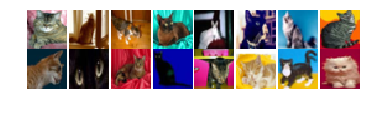

In [7]:
fig, axs = plt.subplots(2, 8, gridspec_kw={'hspace': 0, 
                                           'wspace': 0, 
                                           'top': .4})

for i in range(images_to_sample):
    if i <= 7:
        axs[0, i].imshow(diverse_images[i, :, :, :])
        axs[0, i].axis('off')
    else:
        axs[1, i - 8].imshow(diverse_images[i, :, :, :])
        axs[1, i - 8].axis('off')

### "Similar" images

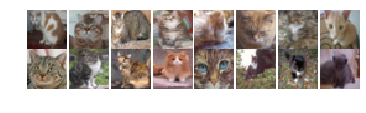

In [8]:
fig, axs = plt.subplots(2, 8, gridspec_kw={'hspace': 0, 
                                           'wspace': 0, 
                                           'top': .4})

for i in range(images_to_sample):
    if i <= 7:
        axs[0, i].imshow(similar_images[i, :, :, :])
        axs[0, i].axis('off')
    else:
        axs[1, i - 8].imshow(similar_images[i, :, :, :])
        axs[1, i - 8].axis('off')

### Random subset

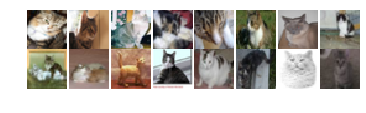

In [9]:
fig, axs = plt.subplots(2, 8, gridspec_kw={'hspace': 0, 
                                           'wspace': 0, 
                                           'top': .4})

for i in range(images_to_sample):
    if i <= 7:
        axs[0, i].imshow(random_images[i, :, :, :])
        axs[0, i].axis('off')
    else:
        axs[1, i - 8].imshow(random_images[i, :, :, :])
        axs[1, i - 8].axis('off')

## Data Editing

When we draw a "diverse" sample, there might be concern that we are picking too many "outliers", or images that look nothing like the others. While we do want to account for the wide range of possible images for a class, choosing images that are especially eccentric might cause the model to put too much weight on that image. 

One method of avoiding this proposed by Wilson in 1972 is editing the training set to remove such outliers, and then training a model on the edited training set. We can try drawing a sample of cat images after removing "outliers":

In [10]:
outlier_ind = np.load('edited-training-data/gist-5nn-removal-indices.npy')

x_train_edited = np.delete(x_train, outlier_ind, 0)
y_train_edited = np.delete(y_train, outlier_ind, 0)
x_gist_edited = np.delete(x_gist, outlier_ind, 0)

x_class_edited = x_train_edited[y_train_edited.flatten() == class_to_sample, :, :, :]
x_gist_class_edited = x_gist_edited[y_train_edited.flatten() == class_to_sample, :]

diverse_gist, diverse_ind = similar_or_diverse(x_gist_class_edited, images_to_sample, 'diverse')
diverse_images_edited = x_class_edited[diverse_ind, :, :, :]

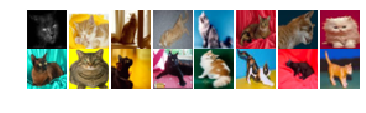

In [11]:
fig, axs = plt.subplots(2, 8, gridspec_kw={'hspace': 0, 
                                           'wspace': 0, 
                                           'top': .4})

for i in range(images_to_sample):
    if i <= 7:
        axs[0, i].imshow(diverse_images_edited[i, :, :, :])
        axs[0, i].axis('off')
    else:
        axs[1, i - 8].imshow(diverse_images_edited[i, :, :, :])
        axs[1, i - 8].axis('off')